In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def process_folder(folder_path, c_values, c_total, BOD1, COD1, BOD31, COD31, Ammonia1, Ammonia31, c_cod_results, c_bod_results):
    BODp = 0.7
    CODp = 0.75

    for filename in os.listdir(folder_path):
        if not filename.endswith(".pkl"):
            continue
        file_path = os.path.join(folder_path, filename)
        c_list = []
        data = []

        try:
            data = pd.read_pickle(file_path)
        except pd.errors.EmptyDataError:
            print(f"Warning: Empty DataFrame in file {file_path}")
            continue

        if data.empty or any(col not in data.columns for col in ['bod1', 'cod1', 'bod31', 'cod31', 'snh1', 'snh31']):
            print(f"Warning: Missing columns in file {file_path}")
            continue

        data['BODut'] = abs((50 - data["bod31"].min()) / (data["bod1"].max() - data["bod31"].min()))
        data['BODlt'] = abs((25 - data["bod31"].min()) / (data["bod1"].max() - data["bod31"].min()))

        data['CODut'] = abs((250 - data["cod31"].min()) / (data["cod1"].max() - data["cod31"].min()))
        data['CODlt'] = abs((125 - data["cod31"].min()) / (data["cod1"].max() - data["cod31"].min()))



        data["LIN_BODe"] = abs((data.bod31 - data["bod31"].min()) / (data["bod1"].max() - data["bod31"].min()))
        data["LIN_CODe"] = abs((data.cod31 - data["cod31"].min()) / (data["cod1"].max() - data["cod31"].min()))
        data["LIN_BODi"] = abs((data.bod1 - data["bod31"].min()) / (data["bod1"].max() - data["bod31"].min()))
        data["LIN_CODi"] = abs((data.cod1 - data["cod31"].min()) / (data["cod1"].max() - data["cod31"].min()))


        data['BODut-BODeffl'] = (data.BODut - data["LIN_BODe"])
        data['CODut-CODeffl'] = (data.CODut - data["LIN_CODe"])
        data['BODlt-BODeffl'] = (data.BODlt - data["LIN_BODe"])
        data['CODlt-CODeffl'] = (data.CODlt - data["LIN_CODe"])

        data["bodp"] = -(BODp * data.LIN_BODi) + data.LIN_BODi - data.LIN_BODe
        data["codp"] = -(CODp * data.LIN_CODi) + data.LIN_CODi - data.LIN_CODe

        data["max1"] = data[['BODlt-BODeffl', 'bodp']].max(axis=1)
        data['c_BOD'] = data[['BODut-BODeffl', 'max1']].min(axis=1)
        data["max2"] = data[['CODlt-CODeffl', 'codp']].max(axis=1)
        data['c_COD'] = data[['CODut-CODeffl', 'max2']].min(axis=1)

        c_bod_list = data['c_BOD'].tolist()
        c_cod_list = data['c_COD'].tolist()

        # FLAGS
        flag_BOD = 'F' if data['BODut-BODeffl'].min() < 0 else 'C'
        flag_COD = 'F' if data['CODut-CODeffl'].min() < 0 else 'C'
        flag_BODlt = 'F' if data['BODlt-BODeffl'].min() < 0 else 'C'
        flag_CODlt = 'F' if data['CODlt-CODeffl'].min() < 0 else 'C'
        flag_reduction_bod = 'F' if data["bodp"].min() < 0 else 'C'
        flag_reduction_cod = 'F' if data["codp"].min() < 0 else 'C'

        for c_bod, c_cod in zip(c_bod_list, c_cod_list):
            failure_type = "COMPLIANT"
            failure_source = None

            if c_bod < 0:
                if flag_BOD == 'F':
                    failure_type = "Maximum failure"
                    failure_source = "BOD"
                else:
                    if flag_BODlt == 'F' and flag_reduction_bod == 'F':
                        failure_type = "LUT failure"
                        failure_source = "BOD"

            if c_cod < 0:
                if flag_COD == 'F':
                    failure_type = "Maximum failure"
                    failure_source = "COD"
                else:
                    if flag_CODlt == 'F' and flag_reduction_cod == 'F':
                        failure_type = "LUT failure"
                        failure_source = "COD"

            # Determine the source of failure if both conditions are met
            if failure_type != "COMPLIANT" and failure_source is None:
                if c_bod < 0 and c_cod < 0:
                    failure_source = "BOTH"
                elif c_bod < 0:
                    failure_source = "BOD"
                elif c_cod < 0:
                    failure_source = "COD"

            c_list.append((min(c_bod, c_cod), failure_type, failure_source))


            if not c_list:
                print(f"Warning: No valid rows in file {file_path}")
                continue

        c_values.append(min(c_list)[0])
        c_total.append(c_list)
        BOD1.append(data['bod1'].tolist())
        COD1.append(data['cod1'].tolist())
        BOD31.append(data['bod31'].tolist())
        COD31.append(data['cod31'].tolist())
        Ammonia1.append(data['snh1'].tolist())
        Ammonia31.append(data['snh31'].tolist())
        c_cod_results.append(c_cod_list)
        c_bod_results.append(c_bod_list)

# Define folder paths
folder_path_1 = 'C:/Users/Anna Stefania Laino/OneDrive - Newcastle University//NEW WORK- OMAR/CSTR/hybrid aeration n1 - mech aeration/composite sample/cstr - gpsx/base_results/baseline'
folder_path_2 = 'C:/Users/Anna Stefania Laino/OneDrive - Newcastle University//NEW WORK- OMAR/CSTR/hybrid aeration n1 - mech aeration/composite sample/cstr - gpsx/base_results/1.3'
folder_path_3 = 'C:/Users/Anna Stefania Laino/OneDrive - Newcastle University//NEW WORK- OMAR/CSTR/hybrid aeration n1 - mech aeration/composite sample/cstr - gpsx/base_results/1.5'
folder_path_4 = 'C:/Users/Anna Stefania Laino/OneDrive - Newcastle University//NEW WORK- OMAR/CSTR/hybrid aeration n1 - mech aeration/composite sample/cstr - gpsx/base_results/1.9'

# Initialize lists for storing data
c_values_baseline = []
c_total_baseline = []
c_cod_baseline = []
c_bod_baseline = []
BOD1_baseline = []
COD1_baseline = []
BOD31_baseline = []
COD31_baseline = []
Ammonia1_baseline = []
Ammonia31_baseline = []

c_values_shift130 = []
c_total_shift130 = []
c_cod_shift130 = []
c_bod_shift130 = []
BOD1_shift130 = []
COD1_shift130 = []
BOD31_shift130 = []
COD31_shift130 = []
Ammonia1_shift130 = []
Ammonia31_shift130 = []

c_values_shift150 = []
c_total_shift150 = []
c_cod_shift150 = []
c_bod_shift150 = []
BOD1_shift150 = []
COD1_shift150 = []
BOD31_shift150 = []
COD31_shift150 = []
Ammonia1_shift150 = []
Ammonia31_shift150 = []

c_values_shift190 = []
c_total_shift190 = []
c_cod_shift190 = []
c_bod_shift190 = []
BOD1_shift190 = []
COD1_shift190 = []
BOD31_shift190 = []
COD31_shift190 = []
Ammonia1_shift190 = []
Ammonia31_shift190 = []

# Process each folder
process_folder(folder_path_1, c_values_baseline, c_total_baseline,  BOD1_baseline, COD1_baseline, BOD31_baseline, COD31_baseline, Ammonia1_baseline, Ammonia31_baseline, c_cod_baseline, c_bod_baseline)
process_folder(folder_path_2, c_values_shift130, c_total_shift130,  BOD1_shift130, COD1_shift130, BOD31_shift130, COD31_shift130, Ammonia1_shift130, Ammonia31_shift130, c_cod_shift130, c_bod_shift130)
process_folder(folder_path_3, c_values_shift150, c_total_shift150,  BOD1_shift150, COD1_shift150, BOD31_shift150, COD31_shift150, Ammonia1_shift150, Ammonia31_shift150, c_bod_shift150, c_cod_shift150)
process_folder(folder_path_4, c_values_shift190, c_total_shift190,  BOD1_shift190, COD1_shift190, BOD31_shift190, COD31_shift190, Ammonia1_shift190, Ammonia31_shift190, c_bod_shift190, c_cod_shift190)

# Define failure types and sources
def extract_failure_types(c_total):
    failure_types = []
    failure_sources = []
    for c_list in c_total:
        for _, failure_type, failure_source in c_list:
            failure_types.append(failure_type)
            failure_sources.append(failure_source)
    return failure_types, failure_sources

# Extract failure types and sources
failure_types_baseline, failure_sources_baseline = extract_failure_types(c_total_baseline)
failure_types_shift130, failure_sources_shift130 = extract_failure_types(c_total_shift130)
failure_types_shift150, failure_sources_shift150 = extract_failure_types(c_total_shift150)
failure_types_shift190, failure_sources_shift190 = extract_failure_types(c_total_shift190)

# Combine the values and failure types into a list of tuples for each dataset
def combine_data(c_values, failure_types, failure_sources):
    return list(zip(c_values, failure_types, failure_sources))

combined_data_baseline = combine_data(c_values_baseline, failure_types_baseline, failure_sources_baseline)
combined_data_shift130 = combine_data(c_values_shift130, failure_types_shift130, failure_sources_shift130)
combined_data_shift150 = combine_data(c_values_shift150, failure_types_shift150, failure_sources_shift150)
combined_data_shift190 = combine_data(c_values_shift190, failure_types_shift190, failure_sources_shift190)

# Print the results
def print_combined_data(label, combined_data):
    print(f"\n{label}:")
    for value, failure_type, failure_source in combined_data:
        print(f"Value: {value}, Failure Type: {failure_type}, Failure Source: {failure_source}")

print_combined_data("Baseline", combined_data_baseline)
print_combined_data("Shift130", combined_data_shift130)
print_combined_data("Shift150", combined_data_shift150)
print_combined_data("Shift190", combined_data_shift190)





Baseline:
Value: -0.0357874699814198, Failure Type: COMPLIANT, Failure Source: None
Value: -0.022684345184719904, Failure Type: COMPLIANT, Failure Source: None
Value: -0.02693304989981756, Failure Type: COMPLIANT, Failure Source: None
Value: -0.034559461053623765, Failure Type: COMPLIANT, Failure Source: None
Value: -0.020561644981068633, Failure Type: COMPLIANT, Failure Source: None
Value: -0.03505325256903636, Failure Type: COMPLIANT, Failure Source: None
Value: -0.028949814948424683, Failure Type: COMPLIANT, Failure Source: None

Shift130:
Value: -0.06135700132963192, Failure Type: COMPLIANT, Failure Source: None
Value: -0.08753532451699253, Failure Type: COMPLIANT, Failure Source: None
Value: -0.07853998812213375, Failure Type: COMPLIANT, Failure Source: None
Value: -0.10758782081243154, Failure Type: COMPLIANT, Failure Source: None
Value: -0.05612191362392711, Failure Type: COMPLIANT, Failure Source: None
Value: -0.06829447100997377, Failure Type: Maximum failure, Failure Source:

In [3]:
# Concatenate the lists for the baseline scenario 
c_total_baseline = np.concatenate([result[1:] for result in c_total_baseline])

bodinfl1_baseline = np.concatenate([result[1:] for result in BOD1_baseline])
bodeffl31_baseline = np.concatenate([result[1:] for result in BOD31_baseline])
codinfl1_baseline = np.concatenate([result[1:] for result in COD1_baseline])
codeffl31_baseline = np.concatenate([result[1:] for result in COD31_baseline])
Ammonia1_baseline = np.concatenate([result[1:] for result in Ammonia1_baseline])
Ammonia31_baseline = np.concatenate([result[1:] for result in Ammonia31_baseline])

# Concatenate the lists for the scenario with a factor of 1.3
c_total_shift130 = np.concatenate([result[1:] for result in c_total_shift130])

bodinfl1_shift130 = np.concatenate([result[1:] for result in BOD1_shift130])
bodeffl31_shift130 = np.concatenate([result[1:] for result in BOD31_shift130])
codinfl1_shift130 = np.concatenate([result[1:] for result in COD1_shift130])
codeffl31_shift130 = np.concatenate([result[1:] for result in COD31_shift130])
Ammonia1_shift130 = np.concatenate([result[1:] for result in Ammonia1_shift130])
Ammonia31_shift130 = np.concatenate([result[1:] for result in Ammonia31_shift130])

# Concatenate the lists for the scenario with a factor of 1.5
c_total_shift150 = np.concatenate([result[1:] for result in c_total_shift150])

bodinfl1_shift150 = np.concatenate([result[1:] for result in BOD1_shift150])
bodeffl31_shift150 = np.concatenate([result[1:] for result in BOD31_shift150])
codinfl1_shift150 = np.concatenate([result[1:] for result in COD1_shift150])
codeffl31_shift150 = np.concatenate([result[1:] for result in COD31_shift150])
Ammonia1_shift150 = np.concatenate([result[1:] for result in Ammonia1_shift150])
Ammonia31_shift150 = np.concatenate([result[1:] for result in Ammonia31_shift150])

# Concatenate the lists for the scenario with a factor of 1.5
c_total_shift190 = np.concatenate([result[1:] for result in c_total_shift190])

bodinfl1_shift190 = np.concatenate([result[1:] for result in BOD1_shift190])
bodeffl31_shift190 = np.concatenate([result[1:] for result in BOD31_shift190])
codinfl1_shift190 = np.concatenate([result[1:] for result in COD1_shift190])
codeffl31_shift190 = np.concatenate([result[1:] for result in COD31_shift190])
Ammonia1_shift190 = np.concatenate([result[1:] for result in Ammonia1_shift190])
Ammonia31_shift190 = np.concatenate([result[1:] for result in Ammonia31_shift190])

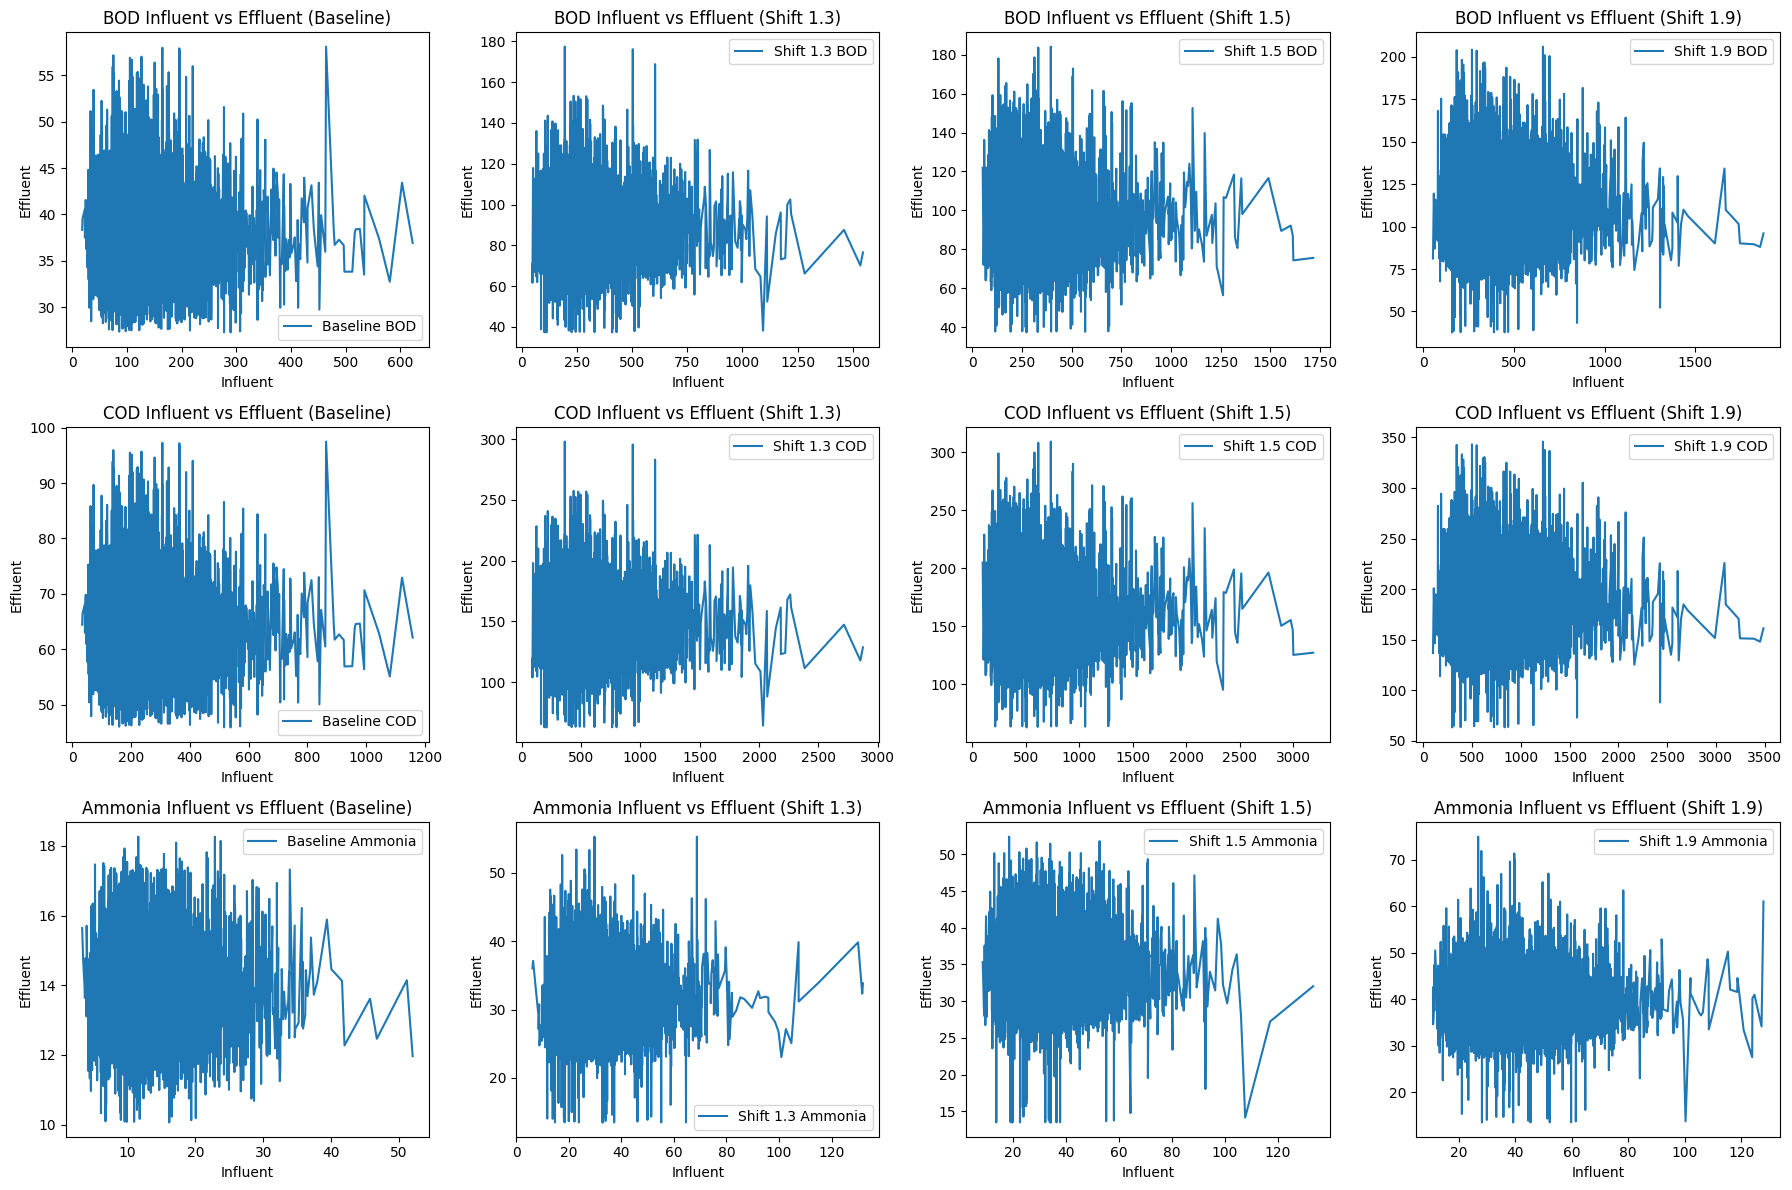

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Create a new figure for each plot
fig, axs = plt.subplots(3, 4, figsize=(18, 12))  # 3 rows, 4 columns

# Define the titles and data for each scenario and parameter
parameters = ['BOD', 'COD', 'Ammonia']
scenarios = ['Baseline', 'Shift 1.3', 'Shift 1.5', 'Shift 1.9']

param_to_influent = {
    'BOD': [bodinfl1_baseline, bodinfl1_shift130, bodinfl1_shift150, bodinfl1_shift190],
    'COD': [codinfl1_baseline, codinfl1_shift130, codinfl1_shift150, codinfl1_shift190],
    'Ammonia': [Ammonia1_baseline, Ammonia1_shift130, Ammonia1_shift150, Ammonia1_shift190]
}

param_to_effluent = {
    'BOD': [bodeffl31_baseline, bodeffl31_shift130, bodeffl31_shift150, bodeffl31_shift190],
    'COD': [codeffl31_baseline, codeffl31_shift130, codeffl31_shift150, codeffl31_shift190],
    'Ammonia': [Ammonia31_baseline, Ammonia31_shift130, Ammonia31_shift150, Ammonia31_shift190]
}

# Loop through parameters and scenarios to generate the plots
for i, param in enumerate(parameters):
    for j, scenario in enumerate(scenarios):
        # Sort the influent and effluent data
        influent_sorted = np.sort(param_to_influent[param][j])
        # Sort the corresponding effluent data based on the sorted influent data
        effluent_sorted = np.array(param_to_effluent[param][j])[np.argsort(param_to_influent[param][j])]
        
        # Plot the sorted data
        axs[i, j].plot(influent_sorted, effluent_sorted, label=f'{scenario} {param}')
        axs[i, j].set_xlabel('Influent')
        axs[i, j].set_ylabel('Effluent')
        axs[i, j].set_title(f'{param} Influent vs Effluent ({scenario})')
        axs[i, j].legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()





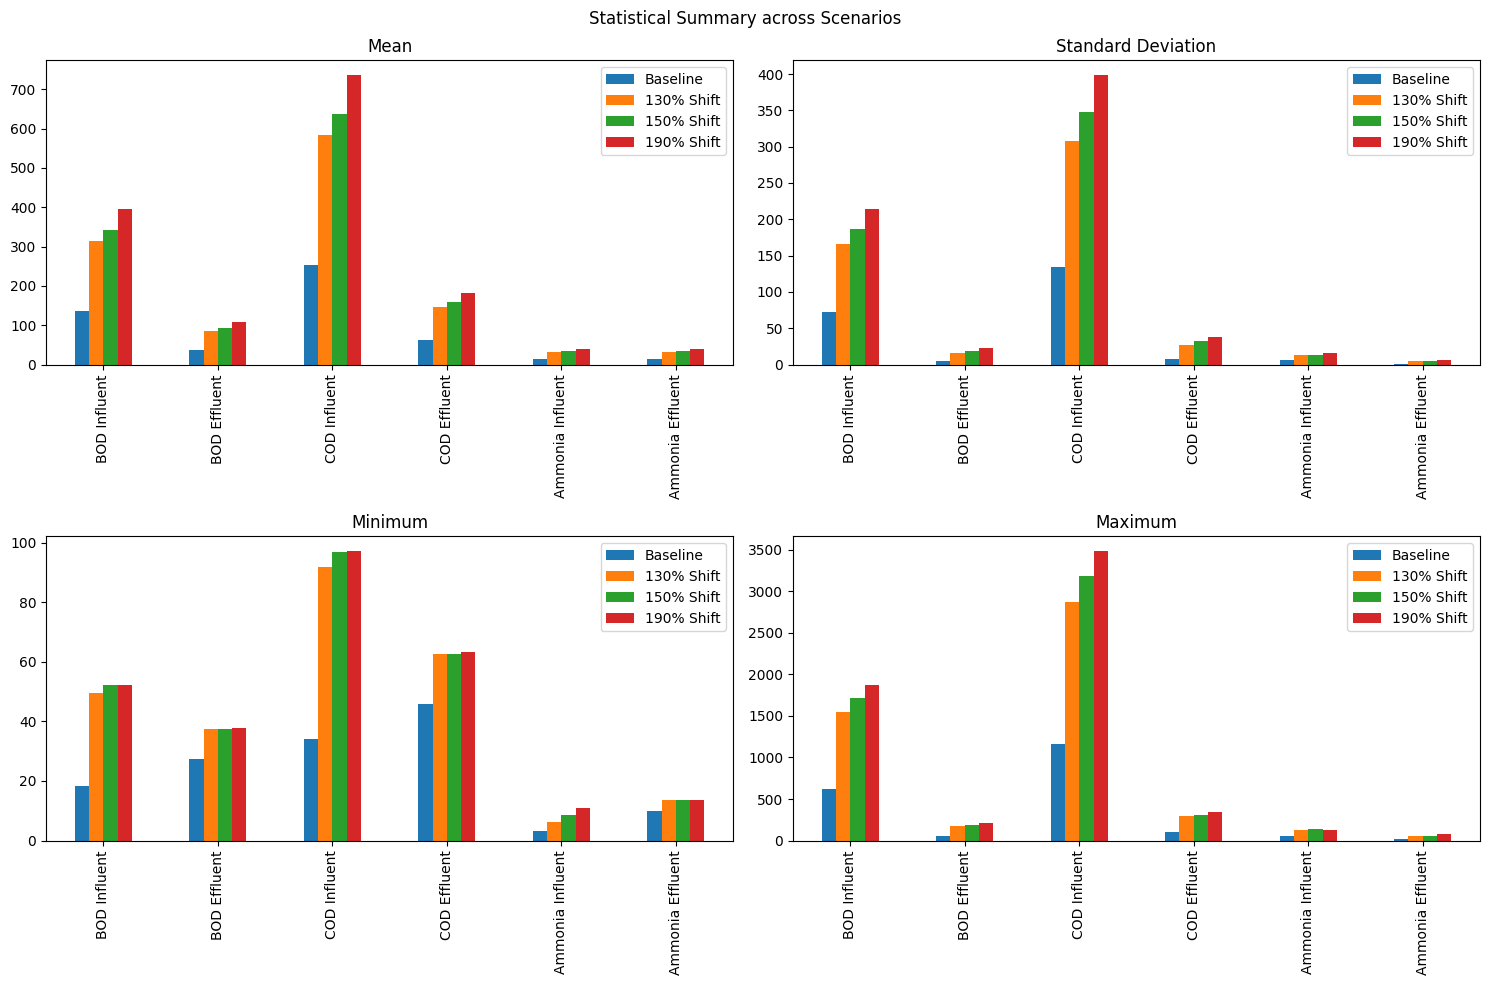

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example arrays for each scenario (replace these with your actual concatenated arrays)
# Assuming the lists are already concatenated as described before

# Create DataFrames and calculate statistics
stats_baseline = pd.DataFrame({
    'mean': [bodinfl1_baseline.mean(), bodeffl31_baseline.mean(), codinfl1_baseline.mean(), codeffl31_baseline.mean(), Ammonia1_baseline.mean(), Ammonia31_baseline.mean()],
    'std': [bodinfl1_baseline.std(), bodeffl31_baseline.std(), codinfl1_baseline.std(), codeffl31_baseline.std(), Ammonia1_baseline.std(), Ammonia31_baseline.std()],
    'min': [bodinfl1_baseline.min(), bodeffl31_baseline.min(), codinfl1_baseline.min(), codeffl31_baseline.min(), Ammonia1_baseline.min(), Ammonia31_baseline.min()],
    'max': [bodinfl1_baseline.max(), bodeffl31_baseline.max(), codinfl1_baseline.max(), codeffl31_baseline.max(), Ammonia1_baseline.max(), Ammonia31_baseline.max()]
}, index=['BOD Influent', 'BOD Effluent', 'COD Influent', 'COD Effluent', 'Ammonia Influent', 'Ammonia Effluent'])

# Repeat for other scenarios
stats_shift130 = pd.DataFrame({
    'mean': [bodinfl1_shift130.mean(), bodeffl31_shift130.mean(), codinfl1_shift130.mean(), codeffl31_shift130.mean(), Ammonia1_shift130.mean(), Ammonia31_shift130.mean()],
    'std': [bodinfl1_shift130.std(), bodeffl31_shift130.std(), codinfl1_shift130.std(), codeffl31_shift130.std(), Ammonia1_shift130.std(), Ammonia31_shift130.std()],
    'min': [bodinfl1_shift130.min(), bodeffl31_shift130.min(), codinfl1_shift130.min(), codeffl31_shift130.min(), Ammonia1_shift130.min(), Ammonia31_shift130.min()],
    'max': [bodinfl1_shift130.max(), bodeffl31_shift130.max(), codinfl1_shift130.max(), codeffl31_shift130.max(), Ammonia1_shift130.max(), Ammonia31_shift130.max()]
}, index=['BOD Influent', 'BOD Effluent', 'COD Influent', 'COD Effluent', 'Ammonia Influent', 'Ammonia Effluent'])

stats_shift150 = pd.DataFrame({
    'mean': [bodinfl1_shift150.mean(), bodeffl31_shift150.mean(), codinfl1_shift150.mean(), codeffl31_shift150.mean(), Ammonia1_shift150.mean(), Ammonia31_shift150.mean()],
    'std': [bodinfl1_shift150.std(), bodeffl31_shift150.std(), codinfl1_shift150.std(), codeffl31_shift150.std(), Ammonia1_shift150.std(), Ammonia31_shift150.std()],
    'min': [bodinfl1_shift150.min(), bodeffl31_shift150.min(), codinfl1_shift150.min(), codeffl31_shift150.min(), Ammonia1_shift150.min(), Ammonia31_shift150.min()],
    'max': [bodinfl1_shift150.max(), bodeffl31_shift150.max(), codinfl1_shift150.max(), codeffl31_shift150.max(), Ammonia1_shift150.max(), Ammonia31_shift150.max()]
}, index=['BOD Influent', 'BOD Effluent', 'COD Influent', 'COD Effluent', 'Ammonia Influent', 'Ammonia Effluent'])

stats_shift190 = pd.DataFrame({
    'mean': [bodinfl1_shift190.mean(), bodeffl31_shift190.mean(), codinfl1_shift190.mean(), codeffl31_shift190.mean(), Ammonia1_shift190.mean(), Ammonia31_shift190.mean()],
    'std': [bodinfl1_shift190.std(), bodeffl31_shift190.std(), codinfl1_shift190.std(), codeffl31_shift190.std(), Ammonia1_shift190.std(), Ammonia31_shift190.std()],
    'min': [bodinfl1_shift190.min(), bodeffl31_shift190.min(), codinfl1_shift190.min(), codeffl31_shift190.min(), Ammonia1_shift190.min(), Ammonia31_shift190.min()],
    'max': [bodinfl1_shift190.max(), bodeffl31_shift190.max(), codinfl1_shift190.max(), codeffl31_shift190.max(), Ammonia1_shift190.max(), Ammonia31_shift190.max()]
}, index=['BOD Influent', 'BOD Effluent', 'COD Influent', 'COD Effluent', 'Ammonia Influent', 'Ammonia Effluent'])

# Combine all the statistics into one DataFrame
combined_stats = pd.concat([stats_baseline, stats_shift130, stats_shift150, stats_shift190], axis=1)
combined_stats.columns = pd.MultiIndex.from_product([['Baseline', '130% Shift', '150% Shift', '190% Shift'], ['mean', 'std', 'min', 'max']])

# Plot the statistics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Statistical Summary across Scenarios')

combined_stats.xs('mean', level=1, axis=1).plot(kind='bar', ax=axes[0, 0], title='Mean')
combined_stats.xs('std', level=1, axis=1).plot(kind='bar', ax=axes[0, 1], title='Standard Deviation')
combined_stats.xs('min', level=1, axis=1).plot(kind='bar', ax=axes[1, 0], title='Minimum')
combined_stats.xs('max', level=1, axis=1).plot(kind='bar', ax=axes[1, 1], title='Maximum')

plt.tight_layout()
plt.show()


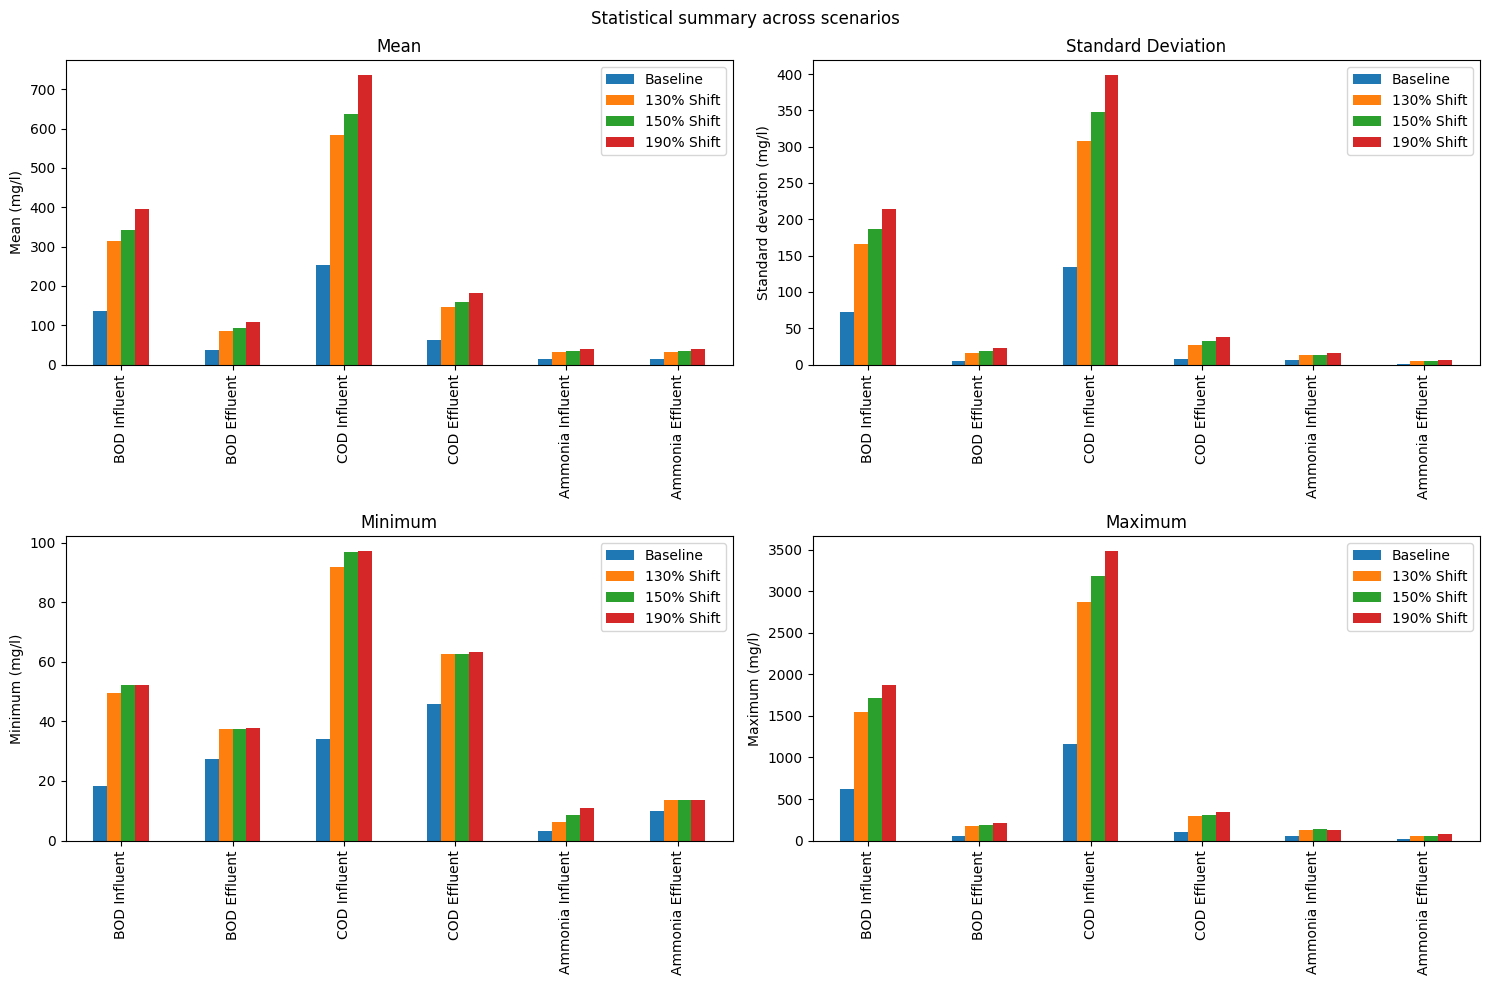

In [6]:
# Plot the statistics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Statistical summary across scenarios')

# Plotting the mean
combined_stats.xs('mean', level=1, axis=1).plot(kind='bar', ax=axes[0, 0], title='Mean')
axes[0, 0].set_ylabel('Mean (mg/l)')

# Plotting the standard deviation
combined_stats.xs('std', level=1, axis=1).plot(kind='bar', ax=axes[0, 1], title='Standard Deviation')
axes[0, 1].set_ylabel('Standard devation (mg/l)')

# Plotting the minimum
combined_stats.xs('min', level=1, axis=1).plot(kind='bar', ax=axes[1, 0], title='Minimum')
axes[1, 0].set_ylabel('Minimum (mg/l)')

# Plotting the maximum
combined_stats.xs('max', level=1, axis=1).plot(kind='bar', ax=axes[1, 1], title='Maximum')
axes[1, 1].set_ylabel('Maximum (mg/l)')

plt.tight_layout()
plt.show()


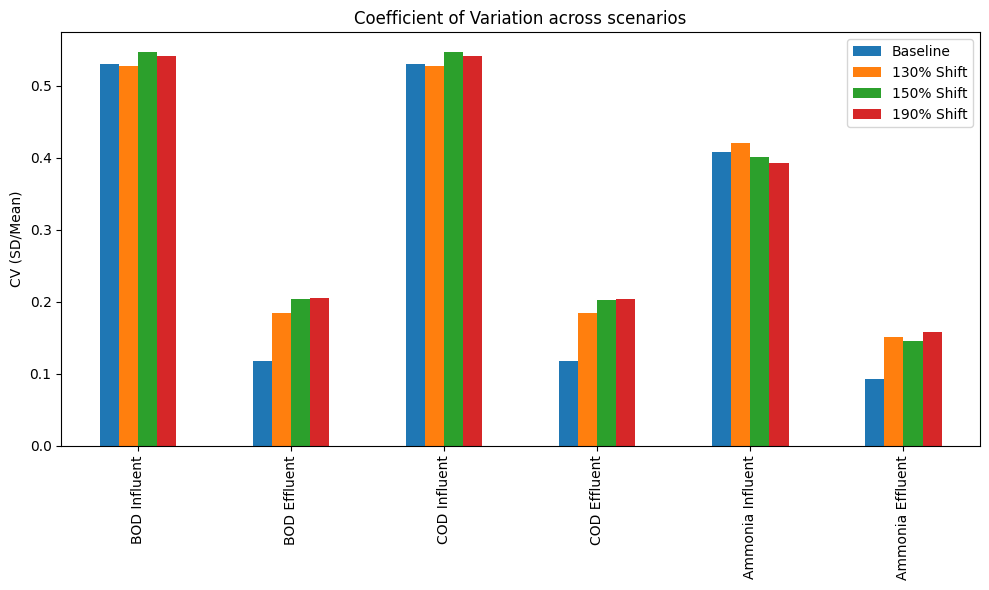

In [7]:
# Compute Coefficient of Variation (CV)
cv = combined_stats.xs('std', level=1, axis=1) / combined_stats.xs('mean', level=1, axis=1)

# Plot the Coefficient of Variation
fig, ax = plt.subplots(figsize=(10, 6))
cv.plot(kind='bar', ax=ax, title='Coefficient of Variation across scenarios')
ax.set_ylabel('CV (SD/Mean)')
plt.tight_layout()
plt.show()


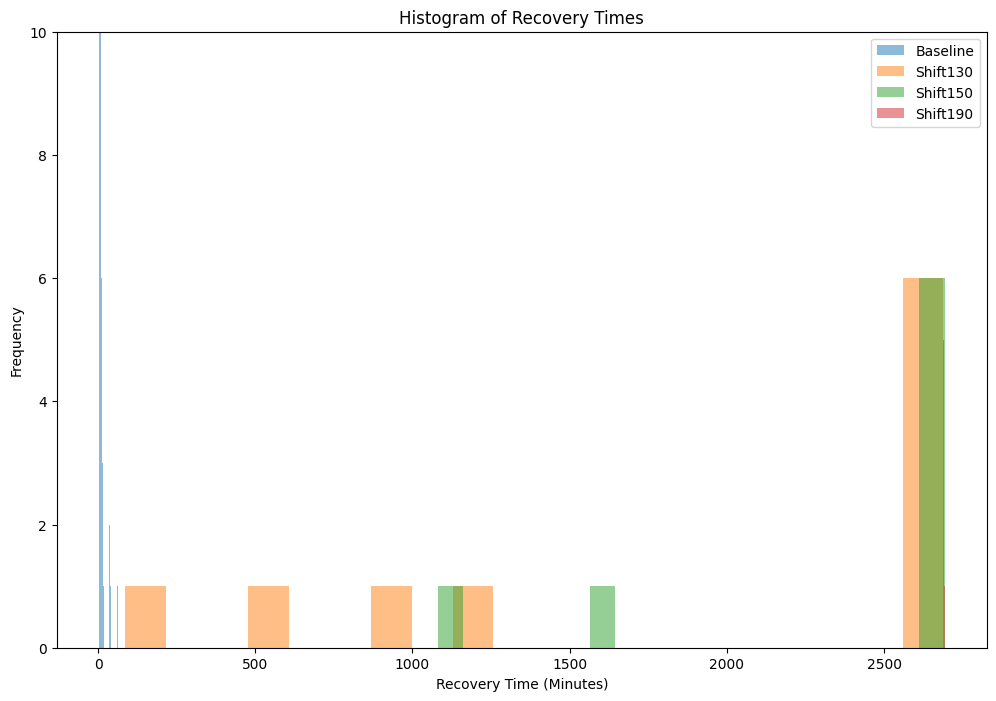

Mean recovery time for baseline: 4.913793103448278 minutes
Mean recovery time for shift130: 1876.6800000000003 minutes
Mean recovery time for shift150: 2350.8 minutes
Mean recovery time for shift190: 2688.6857142857148 minutes


In [8]:
def compute_recovery_time(series, time_step=0.05):
    non_compliance_duration = 0
    recovery_times = []
    in_non_compliance = False

    for _, failure_type, _ in series:  
        if failure_type in ['Maximum failure', 'LUT failure']:
            if not in_non_compliance:
                in_non_compliance = True
            non_compliance_duration += 1
        else:
            if in_non_compliance:
                recovery_time = round(non_compliance_duration * time_step, 2)
                recovery_times.append(recovery_time)
                non_compliance_duration = 0
                in_non_compliance = False

    # Check for ongoing non-compliance at the end of the series
    if in_non_compliance:
        recovery_time = round(non_compliance_duration * time_step, 2)
        recovery_times.append(recovery_time)

    return recovery_times


# Compute recovery times for each series
recovery_times_baseline = compute_recovery_time(c_total_baseline)
recovery_times_shift130 = compute_recovery_time(c_total_shift130)
recovery_times_shift150 = compute_recovery_time(c_total_shift150)
recovery_times_shift190 = compute_recovery_time(c_total_shift190)



# Define the bins for the histogram
bins = 20

# Convert recovery times to minutes
recovery_times_baseline_minutes = [time * 0.05 * 24 * 60 for time in recovery_times_baseline]
recovery_times_shift130_minutes = [time * 0.05 * 24 * 60 for time in recovery_times_shift130]
recovery_times_shift150_minutes = [time * 0.05 * 24 * 60 for time in recovery_times_shift150]
recovery_times_shift190_minutes = [time * 0.05 * 24 * 60 for time in recovery_times_shift190]

# Plot histograms for each scenario
plt.figure(figsize=(12, 8))

plt.hist(recovery_times_baseline_minutes, bins=bins, alpha=0.5, label='Baseline')
plt.hist(recovery_times_shift130_minutes, bins=bins, alpha=0.5, label='Shift130')
plt.hist(recovery_times_shift150_minutes, bins=bins, alpha=0.5, label='Shift150')
plt.hist(recovery_times_shift190_minutes, bins=bins, alpha=0.5, label='Shift190')

plt.xlabel('Recovery Time (Minutes)')
plt.ylabel('Frequency')
plt.title('Histogram of Recovery Times')
plt.legend()
plt.ylim(0,10)
plt.show()



# Convert lists to NumPy arrays
recovery_times_baseline_minutes = np.array(recovery_times_baseline_minutes)
recovery_times_shift130_minutes = np.array(recovery_times_shift130_minutes)
recovery_times_shift150_minutes = np.array(recovery_times_shift150_minutes)
recovery_times_shift190_minutes = np.array(recovery_times_shift190_minutes)

# Calculate the mean for each dataset
mean_baseline = np.mean(recovery_times_baseline_minutes)
mean_shift130 = np.mean(recovery_times_shift130_minutes)
mean_shift150 = np.mean(recovery_times_shift150_minutes)
mean_shift190 = np.mean(recovery_times_shift190_minutes)

print(f"Mean recovery time for baseline: {mean_baseline} minutes")
print(f"Mean recovery time for shift130: {mean_shift130} minutes")
print(f"Mean recovery time for shift150: {mean_shift150} minutes")
print(f"Mean recovery time for shift190: {mean_shift190} minutes")

In [9]:
def compute_recovery_time(series, time_step=0.05):
    non_compliance_duration = 0
    recovery_times = []
    in_non_compliance = False

    for _, failure_type, _ in series:  
        if failure_type in ['Maximum failure', 'LUT failure']:
            if not in_non_compliance:
                in_non_compliance = True
            non_compliance_duration += 1
        else:
            if in_non_compliance:
                recovery_time = round(non_compliance_duration * time_step, 2)
                recovery_times.append(recovery_time)
                non_compliance_duration = 0
                in_non_compliance = False

    # Check for ongoing non-compliance at the end of the series
    if in_non_compliance:
        recovery_time = round(non_compliance_duration * time_step, 2)
        recovery_times.append(recovery_time)

    return recovery_times

# Compute recovery times for each series
recovery_times_baseline = compute_recovery_time(c_total_baseline)
recovery_times_shift130 = compute_recovery_time(c_total_shift130)
recovery_times_shift150 = compute_recovery_time(c_total_shift150)
recovery_times_shift190 = compute_recovery_time(c_total_shift190)

# Convert recovery times to minutes
recovery_times_baseline_minutes = [time * 0.05 * 24 * 60 for time in recovery_times_baseline]
recovery_times_shift130_minutes = [time * 0.05 * 24 * 60 for time in recovery_times_shift130]
recovery_times_shift150_minutes = [time * 0.05 * 24 * 60 for time in recovery_times_shift150]
recovery_times_shift190_minutes = [time * 0.05 * 24 * 60 for time in recovery_times_shift190]

# Convert lists to NumPy arrays
recovery_times_baseline_minutes = np.array(recovery_times_baseline_minutes)
recovery_times_shift130_minutes = np.array(recovery_times_shift130_minutes)
recovery_times_shift150_minutes = np.array(recovery_times_shift150_minutes)
recovery_times_shift190_minutes = np.array(recovery_times_shift190_minutes)

# Calculate the mean for each dataset
mean_baseline = np.mean(recovery_times_baseline_minutes)
mean_shift130 = np.mean(recovery_times_shift130_minutes)
mean_shift150 = np.mean(recovery_times_shift150_minutes)
mean_shift190 = np.mean(recovery_times_shift190_minutes)

print(f"Mean recovery time for baseline: {mean_baseline} minutes")
print(f"Mean recovery time for shift130: {mean_shift130} minutes")
print(f"Mean recovery time for shift150: {mean_shift150} minutes")
print(f"Mean recovery time for shift190: {mean_shift190} minutes")

Mean recovery time for baseline: 4.913793103448278 minutes
Mean recovery time for shift130: 1876.6800000000003 minutes
Mean recovery time for shift150: 2350.8 minutes
Mean recovery time for shift190: 2688.6857142857148 minutes


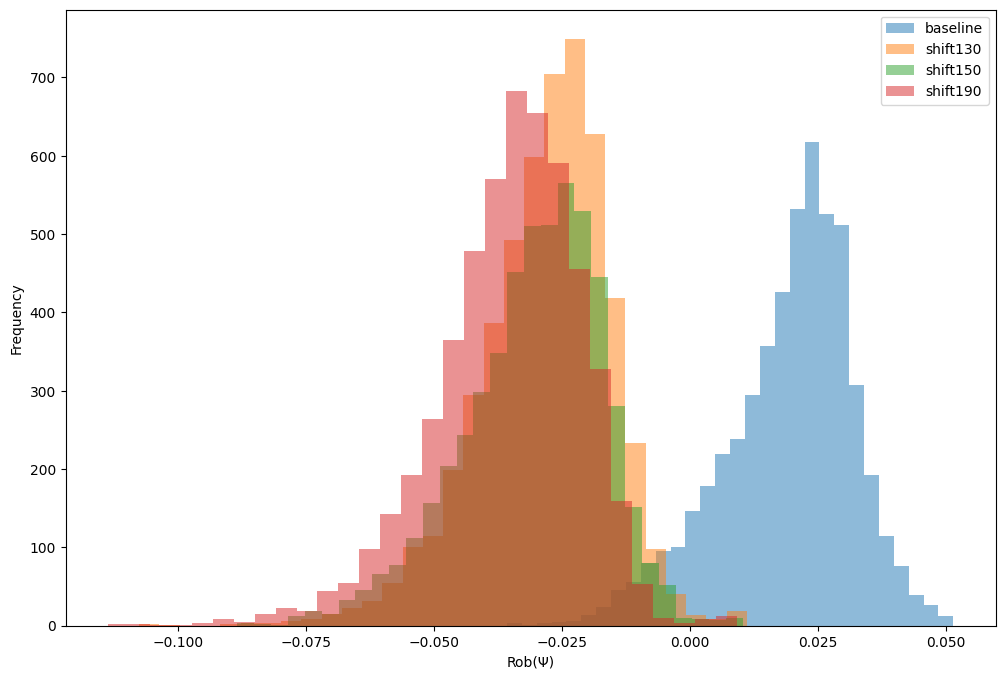

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to flatten nested lists and clean data
def flatten_and_clean(lst):
    flat_list = [item for sublist in lst for item in sublist]
    clean_list = []
    
    for x in flat_list:
        try:
            # Convert to float and check if it's a valid number
            float_x = float(x)
            if not np.isnan(float_x):
                clean_list.append(float_x)
        except (ValueError, TypeError):
            # Skip values that cannot be converted to float
            continue

    return clean_list

# Extract and flatten 'c_total' data for each scenario
c_total_data = {
    "baseline": flatten_and_clean(c_total_baseline),
    "shift130": flatten_and_clean(c_total_shift130),
    "shift150": flatten_and_clean(c_total_shift150),
    "shift190": flatten_and_clean(c_total_shift190)
}

# Plot the histogram
plt.figure(figsize=(12, 8))

# Plot histogram for each scenario
for scenario, values in c_total_data.items():
    plt.hist(values, bins=30, alpha=0.5, label=scenario)

# Add labels and title
plt.xlabel('Rob(Ψ)')
plt.ylabel('Frequency')
#plt.title('Histogram of c_total for Different Scenarios')
plt.legend(loc='upper right')

# Show the plot
plt.show()




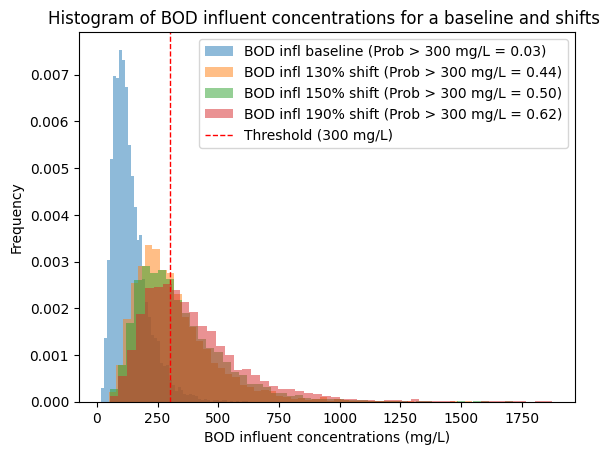

In [11]:

# Count the number of values above 300 mg/L in bodinfl1_baseline
count_baseline_above_300 = sum(1 for value in bodinfl1_baseline if value > 300)
# Calculate the probability
probability_baseline_above_300 = count_baseline_above_300 / len(bodinfl1_baseline)

# Count the number of values above 300 mg/L in bodinfl1_shift130
count_shift130_above_300 = sum(1 for value in bodinfl1_shift130 if value > 300)
# Calculate the probability
probability_shift130_above_300 = count_shift130_above_300 / len(bodinfl1_shift130)

# Count the number of values above 300 mg/L in bodinfl1_shift150
count_shift150_above_300 = sum(1 for value in bodinfl1_shift150 if value > 300)
# Calculate the probability
probability_shift150_above_300 = count_shift150_above_300 / len(bodinfl1_shift150)

# Count the number of values above 300 mg/L in bodinfl1_shift190
count_shift190_above_300 = sum(1 for value in bodinfl1_shift190 if value > 300)
# Calculate the probability
probability_shift190_above_300 = count_shift190_above_300 / len(bodinfl1_shift190)

# Plot histogram for bodinfl_80
plt.hist(bodinfl1_baseline, bins=50, density=True, alpha=0.5, label=f'BOD infl baseline (Prob > 300 mg/L = {probability_baseline_above_300:.2f})')
plt.hist(bodinfl1_shift130, bins=50, density=True, alpha=0.5, label=f'BOD infl 130% shift (Prob > 300 mg/L = {probability_shift130_above_300:.2f})')
plt.hist(bodinfl1_shift150, bins=50, density=True, alpha=0.5, label=f'BOD infl 150% shift (Prob > 300 mg/L = {probability_shift150_above_300:.2f})')
plt.hist(bodinfl1_shift190, bins=50, density=True, alpha=0.5, label=f'BOD infl 190% shift (Prob > 300 mg/L = {probability_shift190_above_300:.2f})')
# Add a dotted line at 300 mg/L
plt.axvline(x=300, color='r', linestyle='--', linewidth=1, label='Threshold (300 mg/L)')

# Set labels and title
plt.xlabel('BOD influent concentrations (mg/L)')
plt.ylabel('Frequency')
plt.title('Histogram of BOD influent concentrations for a baseline and shifts ')

plt.legend()

# Show the plot
plt.show()

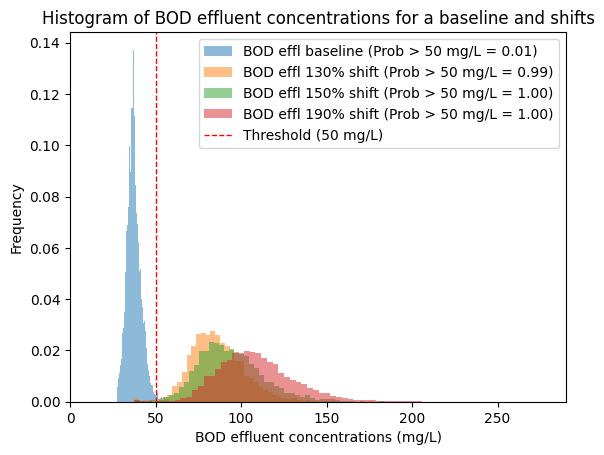

In [12]:
# Count the number of values above 125 mg/L in bodeffl31_baseline
count_baseline_above_50 = sum(1 for value in bodeffl31_baseline if value > 50)
# Calculate the probability
probability_baseline_above_50 = count_baseline_above_50 / len(bodeffl31_baseline)

# Count the number of values above 125 mg/L in bodeffl31_shift130
count_shift130_above_50 = sum(1 for value in bodeffl31_shift130 if value > 50)
# Calculate the probability
probability_shift130_above_50 = count_shift130_above_50 / len(bodeffl31_shift130)

# Count the number of values above 125 mg/L in bodeffl31_shift150
count_shift150_above_50 = sum(1 for value in bodeffl31_shift150 if value > 50)
# Calculate the probability
probability_shift150_above_50 = count_shift150_above_50 / len(bodeffl31_shift150)

# Count the number of values above 125 mg/L in bodeffl31_shift150
count_shift190_above_50 = sum(1 for value in bodeffl31_shift190 if value > 50)
# Calculate the probability
probability_shift190_above_50 = count_shift190_above_50 / len(bodeffl31_shift190)

# Plot histogram for bodeffl31
plt.hist(bodeffl31_baseline, bins=50, density=True, alpha=0.5, label=f'BOD effl baseline (Prob > 50 mg/L = {probability_baseline_above_50:.2f})')
plt.hist(bodeffl31_shift130, bins=50, density=True, alpha=0.5, label=f'BOD effl 130% shift (Prob > 50 mg/L = {probability_shift130_above_50:.2f})')
plt.hist(bodeffl31_shift150, bins=50, density=True, alpha=0.5, label=f'BOD effl 150% shift (Prob > 50 mg/L = {probability_shift150_above_50:.2f})')
plt.hist(bodeffl31_shift190, bins=50, density=True, alpha=0.5, label=f'BOD effl 190% shift (Prob > 50 mg/L = {probability_shift190_above_50:.2f})')

# Add a dotted line at 125 mg/L
plt.axvline(x=50, color='r', linestyle='--', linewidth=1, label='Threshold (50 mg/L)')

# Set labels and title
plt.xlabel('BOD effluent concentrations (mg/L)')
plt.ylabel('Frequency')
plt.title('Histogram of BOD effluent concentrations for a baseline and shifts')
# Set the x-axis limits
plt.xlim(0, 290)
plt.legend()

# Show the plot
plt.show()


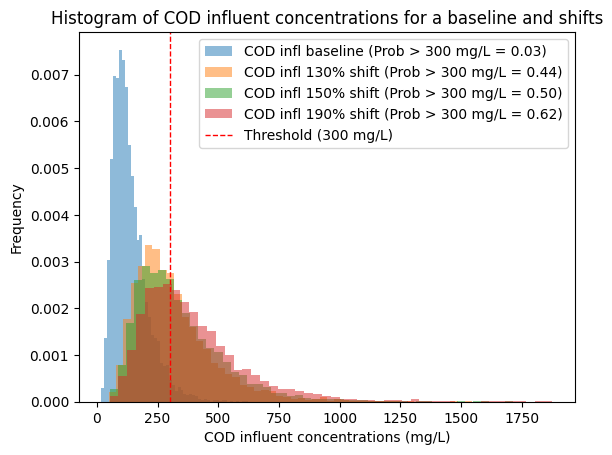

In [13]:
# Count the number of values above 300 mg/L in bodinfl1_baseline
count_baseline_above_300 = sum(1 for value in bodinfl1_baseline if value > 300)
# Calculate the probability
probability_baseline_above_300 = count_baseline_above_300 / len(bodinfl1_baseline)

# Count the number of values above 300 mg/L in bodinfl1_shift130
count_shift130_above_300 = sum(1 for value in bodinfl1_shift130 if value > 300)
# Calculate the probability
probability_shift130_above_300 = count_shift130_above_300 / len(bodinfl1_shift130)

# Count the number of values above 300 mg/L in bodinfl1_shift150
count_shift150_above_300 = sum(1 for value in bodinfl1_shift150 if value > 300)
# Calculate the probability
probability_shift150_above_300 = count_shift150_above_300 / len(bodinfl1_shift150)

# Count the number of values above 300 mg/L in bodinfl1_shift150
count_shift190_above_300 = sum(1 for value in bodinfl1_shift190 if value > 300)
# Calculate the probability
probability_shift190_above_300 = count_shift190_above_300 / len(bodinfl1_shift190)

# Plot histogram for bodinfl_80
plt.hist(bodinfl1_baseline, bins=50, density=True, alpha=0.5, label=f'COD infl baseline (Prob > 300 mg/L = {probability_baseline_above_300:.2f})')
plt.hist(bodinfl1_shift130, bins=50, density=True, alpha=0.5, label=f'COD infl 130% shift (Prob > 300 mg/L = {probability_shift130_above_300:.2f})')
plt.hist(bodinfl1_shift150, bins=50, density=True, alpha=0.5, label=f'COD infl 150% shift (Prob > 300 mg/L = {probability_shift150_above_300:.2f})')
plt.hist(bodinfl1_shift190, bins=50, density=True, alpha=0.5, label=f'COD infl 190% shift (Prob > 300 mg/L = {probability_shift190_above_300:.2f})')
# Add a dotted line at 300 mg/L
plt.axvline(x=300, color='r', linestyle='--', linewidth=1, label='Threshold (300 mg/L)')

# Set labels and title
plt.xlabel('COD influent concentrations (mg/L)')
plt.ylabel('Frequency')
plt.title('Histogram of COD influent concentrations for a baseline and shifts')

plt.legend()

# Show the plot
plt.show()


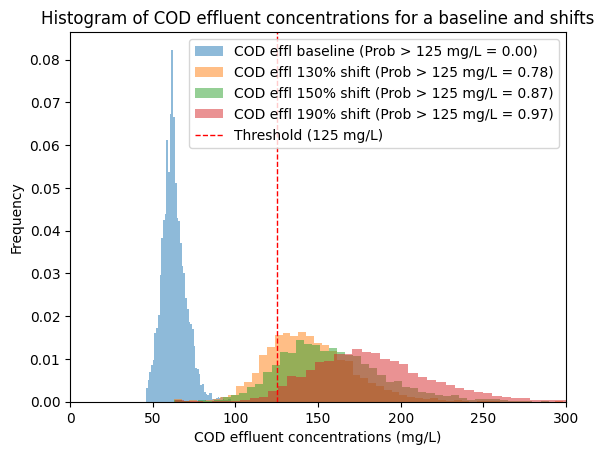

In [14]:
#baseline
count_baseline_above_125 = sum(1 for value in codeffl31_baseline if value > 125)
# Calculate the probability
probability_baseline_above_125 = count_baseline_above_125 / len(codeffl31_baseline)

#130
count_shift130_above_125 = sum(1 for value in codeffl31_shift130 if value > 125)
# Calculate the probability
probability_shift130_above_125 = count_shift130_above_125 / len(codeffl31_shift130)

#150
count_shift150_above_125 = sum(1 for value in codeffl31_shift150 if value > 125)
# Calculate the probability
probability_shift150_above_125 = count_shift150_above_125 / len(codeffl31_shift150)

#190
count_shift190_above_125 = sum(1 for value in codeffl31_shift190 if value > 125)
# Calculate the probability
probability_shift190_above_125 = count_shift190_above_125 / len(codeffl31_shift190)

# Plot histogram for codeffl31
plt.hist(codeffl31_baseline, bins=50, density=True, alpha=0.5, label=f'COD effl baseline (Prob > 125 mg/L = {probability_baseline_above_125:.2f})')
plt.hist(codeffl31_shift130, bins=50, density=True, alpha=0.5, label=f'COD effl 130% shift (Prob > 125 mg/L = {probability_shift130_above_125:.2f})')
plt.hist(codeffl31_shift150, bins=50, density=True, alpha=0.5, label=f'COD effl 150% shift (Prob > 125 mg/L = {probability_shift150_above_125:.2f})')
plt.hist(codeffl31_shift190, bins=50, density=True, alpha=0.5, label=f'COD effl 190% shift (Prob > 125 mg/L = {probability_shift190_above_125:.2f})')

# Add a dotted line at 125 mg/L
plt.axvline(x=125, color='r', linestyle='--', linewidth=1, label='Threshold (125 mg/L)')

# Set labels and title
plt.xlabel('COD effluent concentrations (mg/L)')
plt.ylabel('Frequency')
plt.title('Histogram of COD effluent concentrations for a baseline and shifts')
# Set the x-axis limits
plt.xlim(0, 300)
plt.legend()

# Show the plot
plt.show()


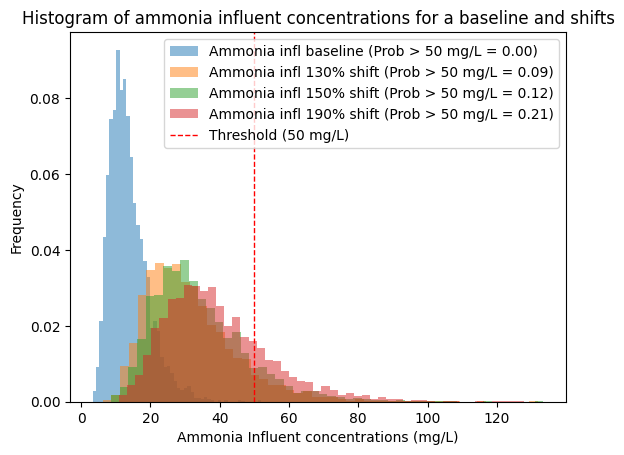

In [15]:
# Baseline
count_baseline_above_50 = sum(1 for value in Ammonia1_baseline if value > 50)
# Calculate the probability
probability_baseline_above_50 = count_baseline_above_50 / len(Ammonia1_baseline)

# 130% shift
count_shift130_above_50 = sum(1 for value in Ammonia1_shift130 if value > 50)
# Calculate the probability
probability_shift130_above_50 = count_shift130_above_50 / len(Ammonia1_shift130)

# 150% shift
count_shift150_above_50 = sum(1 for value in Ammonia1_shift150 if value > 50)
# Calculate the probability
probability_shift150_above_50 = count_shift150_above_50 / len(Ammonia1_shift150)

# 190% shift
count_shift190_above_50 = sum(1 for value in Ammonia1_shift190 if value > 50)
# Calculate the probability
probability_shift190_above_50 = count_shift190_above_50 / len(Ammonia1_shift190)

# Plot histogram
plt.hist(Ammonia1_baseline, bins=50, density=True, alpha=0.5, label=f'Ammonia infl baseline (Prob > 50 mg/L = {probability_baseline_above_50:.2f})')
plt.hist(Ammonia1_shift130, bins=50, density=True, alpha=0.5, label=f'Ammonia infl 130% shift (Prob > 50 mg/L = {probability_shift130_above_50:.2f})')
plt.hist(Ammonia1_shift150, bins=50, density=True, alpha=0.5, label=f'Ammonia infl 150% shift (Prob > 50 mg/L = {probability_shift150_above_50:.2f})')
plt.hist(Ammonia1_shift190, bins=50, density=True, alpha=0.5, label=f'Ammonia infl 190% shift (Prob > 50 mg/L = {probability_shift190_above_50:.2f})')
# Add a dotted line at 20 mg/L
plt.axvline(x=50, color='r', linestyle='--', linewidth=1, label='Threshold (50 mg/L)')

# Set labels and title
plt.xlabel('Ammonia Influent concentrations (mg/L)')
plt.ylabel('Frequency')
plt.title('Histogram of ammonia influent concentrations for a baseline and shifts')

plt.legend()

# Show the plot
plt.show()


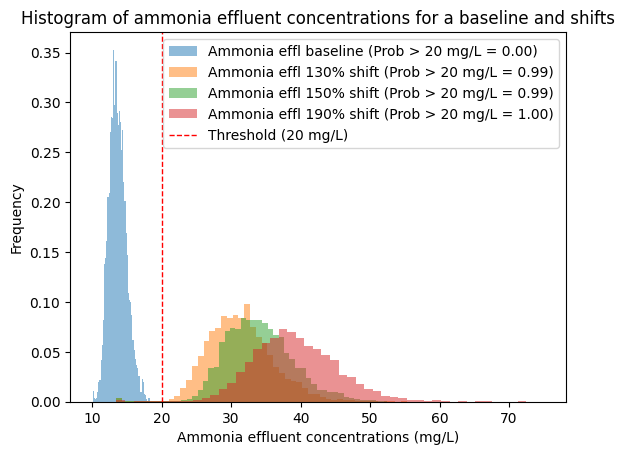

In [16]:
# Baseline
count_baseline_above_20 = sum(1 for value in Ammonia31_baseline if value > 20)
# Calculate the probability
probability_baseline_above_20 = count_baseline_above_20 / len(Ammonia31_baseline)

# 130% shift
count_shift130_above_20 = sum(1 for value in Ammonia31_shift130 if value > 20)
# Calculate the probability
probability_shift130_above_20 = count_shift130_above_20 / len(Ammonia31_shift130)

# 150% shift
count_shift150_above_20 = sum(1 for value in Ammonia31_shift150 if value > 20)
# Calculate the probability
probability_shift150_above_20 = count_shift150_above_20 / len(Ammonia31_shift150)

# 190% shift
count_shift190_above_20 = sum(1 for value in Ammonia31_shift190 if value > 20)
# Calculate the probability
probability_shift190_above_20 = count_shift190_above_20 / len(Ammonia31_shift190)

# Plot histogram
plt.hist(Ammonia31_baseline, bins=50, density=True, alpha=0.5, label=f'Ammonia effl baseline (Prob > 20 mg/L = {probability_baseline_above_20:.2f})')
plt.hist(Ammonia31_shift130, bins=50, density=True, alpha=0.5, label=f'Ammonia effl 130% shift (Prob > 20 mg/L = {probability_shift130_above_20:.2f})')
plt.hist(Ammonia31_shift150, bins=50, density=True, alpha=0.5, label=f'Ammonia effl 150% shift (Prob > 20 mg/L = {probability_shift150_above_20:.2f})')
plt.hist(Ammonia31_shift190, bins=50, density=True, alpha=0.5, label=f'Ammonia effl 190% shift (Prob > 20 mg/L = {probability_shift190_above_20:.2f})')
# Add a dotted line at 20 mg/L
plt.axvline(x=20, color='r', linestyle='--', linewidth=1, label='Threshold (20 mg/L)')

# Set labels and title
plt.xlabel('Ammonia effluent concentrations (mg/L)')
plt.ylabel('Frequency')
plt.title('Histogram of ammonia effluent concentrations for a baseline and shifts')

plt.legend()

# Show the plot
plt.show()
